In [254]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, chi2
from sklearn.pipeline import Pipeline

def read_data_file(filename: str) -> pd.DataFrame:
    path = Path(os.getcwd() + 'q1.ipynb')
    data_folder = str(path.parent.absolute()) + '/data/'
    return pd.read_csv(data_folder + filename)


features = read_data_file('CATSnDOGS.csv') / 255
#features = (features - features.mean()) / 255 # center and normalize
labels = read_data_file('Labels.csv')

models = [
          ('SVM', SVC()),
          ('LogReg', LogisticRegression(max_iter=1000)), 
          ('RF', RandomForestClassifier())
        ]

In [224]:
def evaluate_ensemble(models: list, features: pd.DataFrame, labels: pd.DataFrame) -> tuple:
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, stratify=labels, random_state=None)
    dfs = []
    scoring = ['accuracy', 'precision', 'recall', 'f1']
    trained_models = {}

    for name, model in models:
        kfold = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
        cross_validate(model, X_train, y_train.to_numpy().ravel(), cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train.to_numpy().ravel())
        y_pred = clf.predict(X_test)
        
        trained_models[name] = clf
        df = pd.DataFrame({'_id': y_test.index.values, 'true': y_test.to_numpy().ravel(), 'predicted': y_pred, 'model': name})
        dfs.append(df)

    result = pd.concat(dfs, ignore_index=True)
    return trained_models, result


def average_scores(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int=5) -> tuple:
    matrix = []
    for it in range(iter):
        _, res = evaluate_ensemble(models, features, labels)
        scores = calc_scores(res)
        matrix.append(scores)
    
    mean = np.mean(matrix, axis=0)
    std = np.std(matrix, axis=0)
    return mean, std

    
def calc_scores(ensemble_result: pd.DataFrame) -> np.ndarray:
    model_names = ensemble_result.model.unique()
    scores = np.zeros((len(model_names), 3))

    for i, name in enumerate(model_names):
        this_df = ensemble_result[ensemble_result.model == name]
        y_true = this_df['true']
        y_pred = this_df['predicted']

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        cat_accuracy = tn / (tn + fp) # specificity
        dog_accuracy = tp / (tp + fn) # recall
        accuracy = (tn + tp)/(tn + fp + fn + tp)
        scores[i][0] = cat_accuracy
        scores[i][1] = dog_accuracy
        scores[i][2] = accuracy

    return scores


def detect_mislabels(models: list, features: pd.DataFrame, labels: pd.DataFrame, iter: int = 5, vote_limit: float = 0.5) -> dict:  
    mislabels = {}
    dfs = []

    for it in range(iter):
        _, res = evaluate_ensemble(models, features, labels)
        res['vote'] = np.absolute(res.true-res.predicted)
        dfs.append(res)

    df = pd.concat(dfs, ignore_index=True)
    model_names = df.model.unique()

    for i, name in enumerate(model_names):
        mislabelled_ids = []
        model_df = df[df.model == name]
        _ids = model_df._id.unique()

        for _id in _ids:
            _id_df = model_df[model_df._id == _id]
            total = len(_id_df.index)
            vote = _id_df['vote'].sum()
            
            if vote/total < vote_limit:
                continue
            else:
                mislabelled_ids.append(_id)

        mislabels[name] = mislabelled_ids

    return mislabels

iterations = 50
trained_models, _ = evaluate_ensemble(models, features, labels)
mean, std = average_scores(models, features, labels, iter=20)
mislabels = detect_mislabels(models, features, labels, iter=20, vote_limit=1.0)

Are the cats and dogs well separated, i.e. can you obtain good classification test accuracy performance on this data set? Compare at least 3 classifiers.

_Answer:_

In [221]:
names = ['SVM', 'LogReg', 'RF']
for i, name in enumerate(names):
    print(name + " - mean accuracies (std) \n cat (specificity): %f (%f) \n dog (recall): %f (%f) \n overall: %f (%f) \n" % (mean[i][0], std[i,0], mean[i][1], std[i,1], mean[i][2], std[i,2]))

SVM - mean accuracies (std) 
 cat (specificity): 0.842500 (0.090250) 
 dog (recall): 0.750769 (0.104977) 
 overall: 0.794800 (0.058352) 

LogReg - mean accuracies (std) 
 cat (specificity): 0.804167 (0.091761) 
 dog (recall): 0.719231 (0.093975) 
 overall: 0.760000 (0.049477) 

RF - mean accuracies (std) 
 cat (specificity): 0.740833 (0.096570) 
 dog (recall): 0.740769 (0.091603) 
 overall: 0.740800 (0.059727) 



Are there any images that are consistently mislabeled by the classifiers (use resampling to ascertain)? 

Do the classifiers struggle with the same observations?

_Answer:_

In [226]:
mislabels_svm = set(mislabels['SVM'])
mislabels_logreg = set(mislabels['LogReg'])
mislabels_rf = set(mislabels['RF'])

intersection = mislabels_svm.intersection(mislabels_logreg).intersection(mislabels_rf)
all = [('SVM', mislabels_svm), ('LogReg', mislabels_logreg), ('RF', mislabels_rf)]
for name, mislabel in all:
    print("About %s percent of mislabels by the %s is shared by all models." % (np.around((len(intersection)/len(mislabel)*100), 2), name))

About 50.0 percent of mislabels by the SVM is shared by all models.
About 58.33 percent of mislabels by the LogReg is shared by all models.
About 41.18 percent of mislabels by the RF is shared by all models.


Why do you think these are difficult images to classify?

Are the errors balanced or is one class more difficult to classify correctly?

_Answer:_

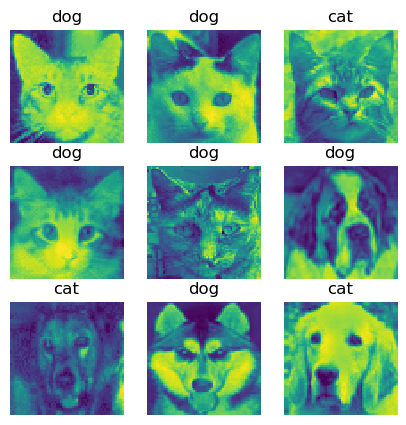

Fraction of missclassified dogs: 0.714286
Fraction of missclassified cats: 0.285714 
(according to algorithm)


In [227]:
#print("Intersection: %s" % intersection)
sub_sample = np.array(list(intersection))[:9]
fig, axes = plt.subplots(3, 3, figsize=(5,5))
imgs = zip(sub_sample, axes.flatten())

for _id, ax in imgs:
    sample = features.iloc[_id,:]
    data = np.array(sample).reshape(64,64).T
    ax.imshow(data, interpolation='nearest')
    ax.axis('off')

    if labels.iat[_id,0] == 1:
        ax.set_title('True label: dog')
    else:
        ax.set_title('True label: cat')
plt.show()

tmp = labels.iloc[list(intersection), 0]
frac_mislabeled_dogs = tmp.sum() / len(tmp)
frac_mislabeled_cats = 1 - frac_mislabeled_dogs
print('Fraction of missclassified dogs: %f' % frac_mislabeled_dogs)
print('Fraction of missclassified cats: %f \n(according to algorithm)' % frac_mislabeled_cats)